# Prediction of energy consumption of non-residential buildings in San Francisco

July 2019

*Project Description:*

We will use this dataset to analyse and predict the Froth floating process having the two aims:

What is the best predictor for the iron concentration of the product?
Can the data set be used to predict the impurity of the product (by silicate concentration)?

*Data Description:*

This notebook deals with the analysis of a reverse cationic flotation process of a real production environment. The data (including its documentation) is accessible through kaggle: https://www.kaggle.com/san-francisco/sf-commercial-buildings-energy-performance-report/downloads/sf-commercial-buildings-energy-performance-report.zip/104

---

## Data Analysis
We start our analysis by importing required libraries:

In [319]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt; plt.style.use('seaborn-colorblind')
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import datetime as dt
from datetime import date

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics

# include fasti.ai libraries
from fastai.tabular import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
from IPython.display import display
pd.set_option('display.max_columns', None) # display all columns

import warnings
warnings.filterwarnings("ignore")

# Any results you write to the current directory are saved as output.

We load the data and drop some columns that dont seem to be useful for our analysis:

In [166]:
#PATH = 'existing-commercial-buildings-energy-performance-ordinance-report.csv'
PATH = 'spain_energy_market.csv'
#nRowsRead = 1
#df_null = pd.read_csv(PATH,nrows = nRowsRead)

#all_cols = df_null.columns
#skipcols = ['Full.Address','PIM Link',':@computed_region_f58d_8dbm',':@computed_region_vtsz_7cme',':@computed_region_rxqg_mtj9',':@computed_region_jx4q_fizf']

#df = pd.read_csv(PATH,usecols=set(all_cols) - set(skipcols))
df = pd.read_csv(PATH, parse_dates = True, date_parser = 'datetime')

Let's have a look at the data:

In [159]:
df.head()

,datetime,id,name,geoid,geoname,value
0,2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833
1,2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167
2,2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083
3,2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667
4,2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500


Lets create additional Time data columns:

In [167]:
df['date'] = pd.to_datetime(df['datetime'])
df['dayofweek'] = df['date'].dt.dayofweek
df['quarter'] = df['date'].dt.quarter
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofyear'] = df['date'].dt.dayofyear
df['dayofmonth'] = df['date'].dt.day
df['weekofyear'] = df['date'].dt.weekofyear
df = df.set_index(['date'])

In [168]:
df.drop(['datetime'], axis=1,inplace=True)

In [163]:
df['name'].unique()

array(['Precio mercado SPOT Diario ESP', 'Precio mercado SPOT Diario FRA', 'Precio mercado SPOT Diario POR',
       'Energía asignada en Mercado SPOT Diario España', 'Energía asignada en Mercado SPOT Diario Francia', nan,
       'Rentas de congestión mecanismos implícitos diario Francia exportación',
       'Rentas de congestión mecanismos implícitos diario Portugal exportación',
       'Rentas de congestión mecanismos implícitos diario Francia importación',
       'Rentas de congestión mecanismos implícitos diario Portugal importación', 'Demanda real',
       'Demanda programada PBF total', 'Generación programada PBF total', 'Generación programada PBF Eólica',
       'Generación programada PBF Ciclo combinado', 'Generación programada PBF Carbón',
       'Generación programada PBF Nuclear', 'Generación programada PBF Gas Natural Cogeneración',
       'Generación programada PBF UGH + no UGH', 'Generación programada PBF Solar fotovoltaica',
       'Generación programada PBF Turbinación b

Since multiple time series are contained in our column data, we need to seperate the different features. Lets create new dataframes of the 'real Demand' the 'scheduled Demand' and the 'Daily spot Spain market price'.

In [233]:
Demand_real  = df[df['name'] == 'Demanda real']
Demand_sche  = df[df['name'] == 'Demanda programada PBF total']
Price        = df[df['name'] == 'Precio mercado SPOT Diario ESP']
Price.head()

,id,name,geoid,geoname,value,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,,
2014-01-01 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,25.280833,23,2,1,1,2014,1,1,1
2014-01-02 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,39.924167,23,3,1,1,2014,2,2,1
2014-01-03 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.992083,23,4,1,1,2014,3,3,1
2014-01-04 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,4.091667,23,5,1,1,2014,4,4,1
2014-01-05 23:00:00,600,Precio mercado SPOT Diario ESP,3.0,España,13.587500,23,6,1,1,2014,5,5,1


Price development over whole timespan:

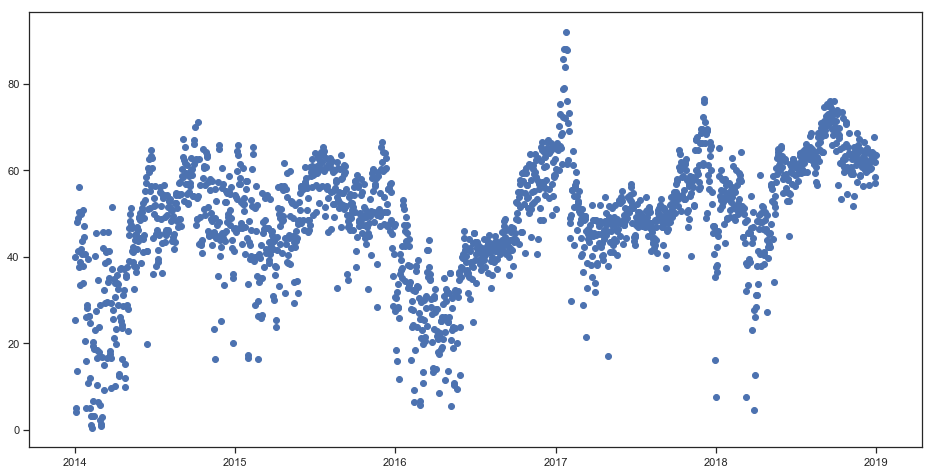

In [271]:
plt.figure(figsize=(15,5))
plt.scatter(x=Price.index,y=Price['value'])

We can see that the price development undergoes some seasonal changes. To further explore this, lets visualize the data for different time attributes, like price per day of week, week of year, quarter and year.

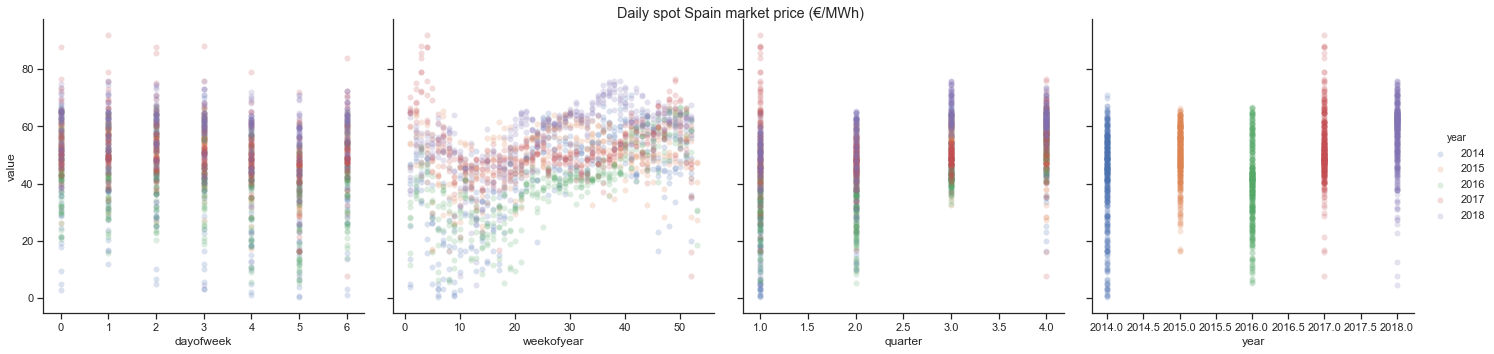

In [228]:
sns.pairplot(Price,
             hue='year',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Daily spot Spain market price (€/MWh)')
plt.show()

We repeat this for the expected energy demand and the actual demand...

<Figure size 1152x720 with 0 Axes>

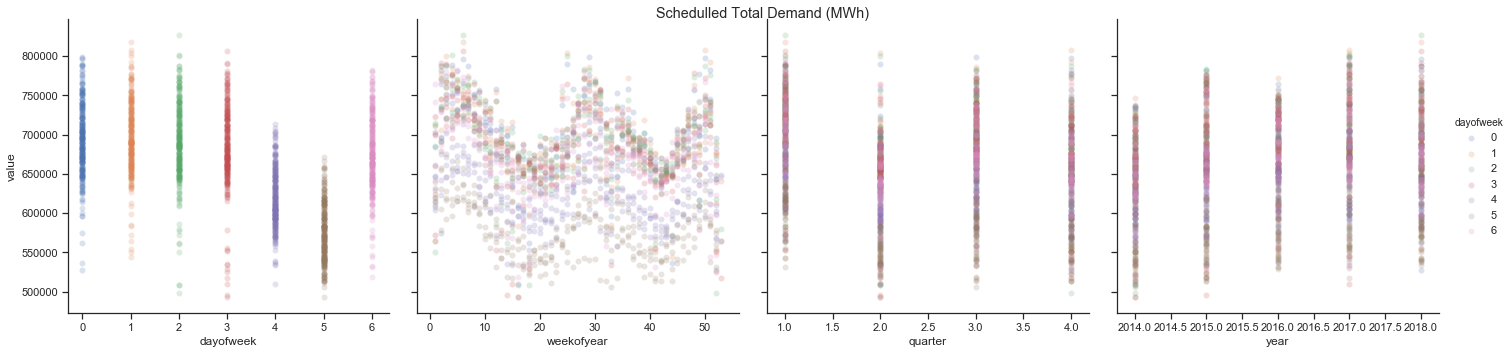

In [229]:
plt.figure(figsize=(16,10))
sns.pairplot(Demand_sche,
             hue='dayofweek',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Schedulled Total Demand (MWh)')
plt.show()

<Figure size 1152x720 with 0 Axes>

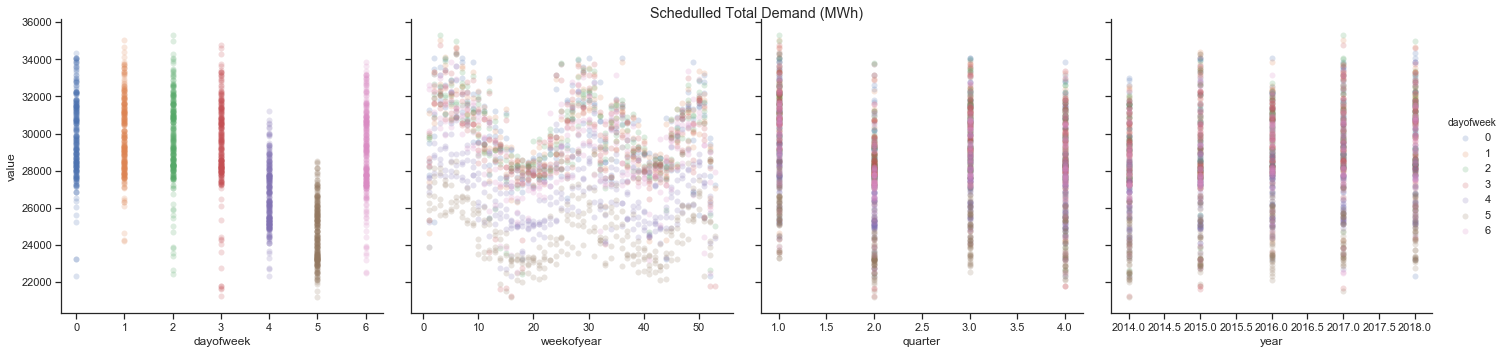

In [230]:
plt.figure(figsize=(15,10))
sns.pairplot(Demand_real,
             hue='dayofweek',
             x_vars=['dayofweek','weekofyear','quarter','year'],
             y_vars='value',
             height=5,
             plot_kws={'alpha':0.2, 'linewidth':0}
            )
plt.suptitle('Schedulled Total Demand (MWh)')
plt.show()

### Observations

Based on our quick visualization we can derive the following observations:

- the daily market price has a long-term dependency (quarterly or yearly fluctuations), while
- the demand seems to be strongly influenced by the days of the week (see drop on weekend)

## Prediction of daily price

Lets see if we can predict the market price. We start by splitting the data into training and test set. Lets take the 2018-01-01 as split-date.

In [301]:
date_split = '2018-01-01'
train = Price['value'].loc[Price.index <= date_split].copy()
train = train.reset_index()
test = Price['value'].loc[Price.index > date_split].copy()
test = test.reset_index()
test.head()

,date,value
0,2018-01-01 23:00:00,37.690000
1,2018-01-02 23:00:00,37.947917
2,2018-01-03 23:00:00,36.551667
3,2018-01-04 23:00:00,42.204583
4,2018-01-05 23:00:00,45.844167


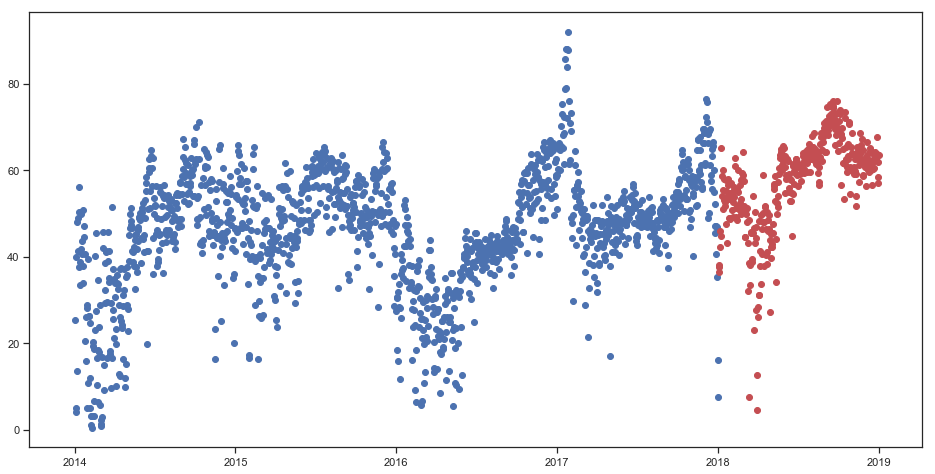

In [273]:
plt.figure(figsize=(15,5))
plt.scatter(x=train['date'],y=train['value'],c='b')
plt.scatter(x=test['date'],y=test['value'],c='r')


Now, we train a Prophet model from Facebook (https://facebook.github.io/prophet/), used to forecast time series that undergo seasonal trends.

In [276]:
from fbprophet import Prophet

In [277]:
model = Prophet()
model.fit(train.rename(columns={'date':'ds', 'value':'y'}))

/Users/LL/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



Forcasting from training set:

In [292]:
price_predict = model.predict(df=test.rename(columns={'date':'ds'}))

Let's see the forecast (and compare against actual data):

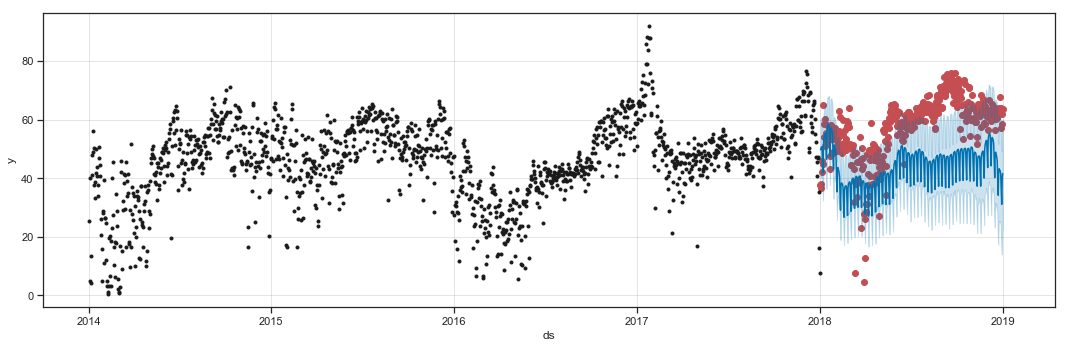

In [298]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['date'], test['value'], color='r')
fig = model.plot(price_predict, ax=ax)

Ok, that does not look to good. Lets see if we can get better predictions, if we exclude data that is to old, e.g. earlier than 2016. 

In [302]:
date_start = '2016-01-01'
train = train.loc[train['date'] >= date_start].copy()
train.head()

,date,value
730,2016-01-01 23:00:00,30.725000
731,2016-01-02 23:00:00,18.477083
732,2016-01-03 23:00:00,30.463333
733,2016-01-04 23:00:00,31.770833
734,2016-01-05 23:00:00,15.883333


Retrain the model:

In [308]:
model2 = Prophet()
model2.fit(train.rename(columns={'date':'ds', 'value':'y'}))

In [311]:
future = model2.make_future_dataframe(periods=365)
future.tail()

,ds
1091,2018-12-27 23:00:00
1092,2018-12-28 23:00:00
1093,2018-12-29 23:00:00
1094,2018-12-30 23:00:00
1095,2018-12-31 23:00:00


In [313]:
forecast = model2.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1091,2018-12-27 23:00:00,48.511035,40.183240,57.419239
1092,2018-12-28 23:00:00,43.779627,35.037219,52.765933
1093,2018-12-29 23:00:00,39.208361,30.872295,48.115956
1094,2018-12-30 23:00:00,46.985464,37.666029,56.036459
1095,2018-12-31 23:00:00,49.728160,40.721662,58.702991


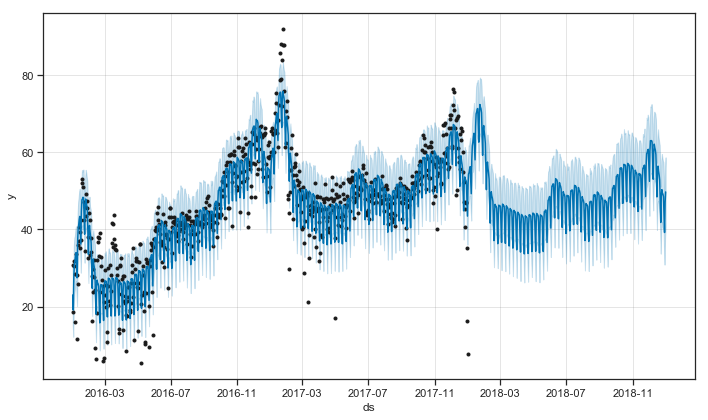

In [315]:
fig1 = model2.plot(forecast)

In [306]:
price_predict2 = model2.predict(df=test.rename(columns={'date':'ds'}))

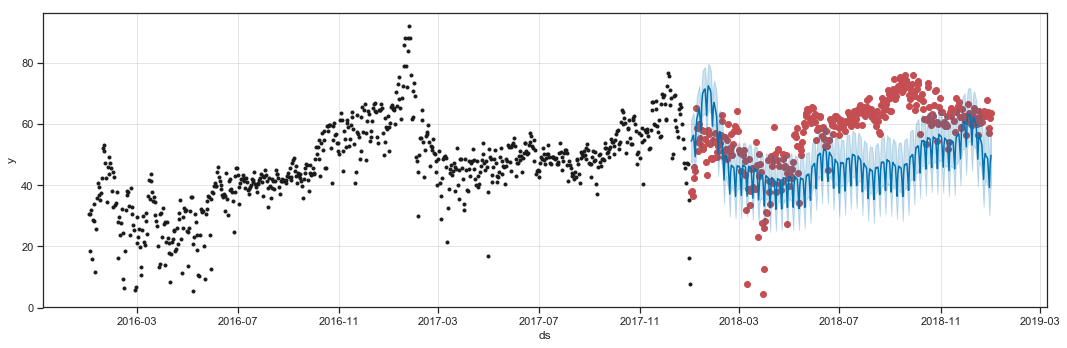

In [317]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test['date'], test['value'], color='r')
fig = model2.plot(price_predict2, ax=ax)

The prediction still does not seem to describe our data well. Yearly, weekly and daily trends can be seen in the following figure:

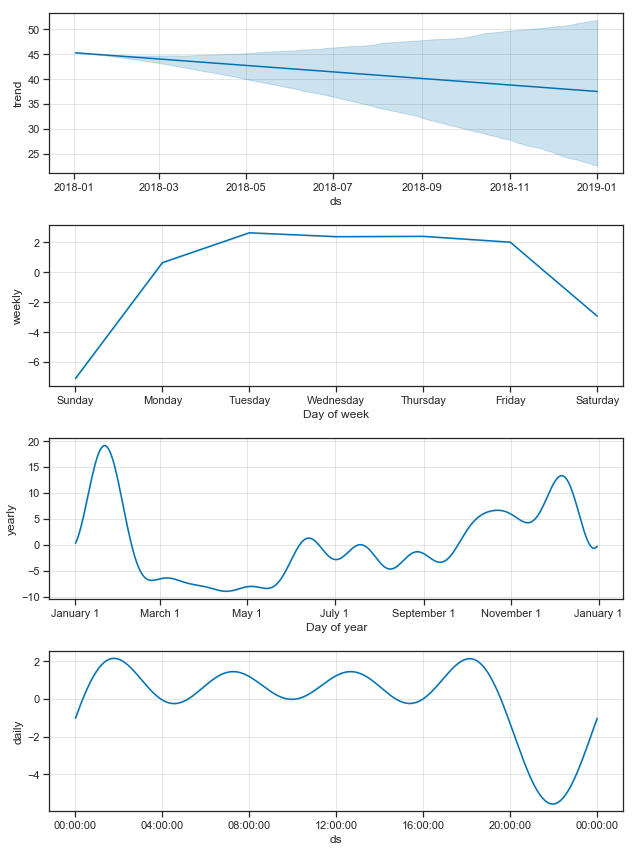

In [365]:
fig = model.plot_components(price_predict)

---


We can also try to include holiday information:

In [364]:
from workalendar.europe import Spain
cal = Spain()
holdidays_2018 = cal.holidays(2018)
holdidays_2018[0]

TypeError: list indices must be integers or slices, not list

In [328]:
train_holidays = cal.holidays(start=train['date'].min(), end=train['date'].max())
test_holidays = cal.holidays(start=train['date'].min(), end=test['date'].max())

TypeError: holidays() got an unexpected keyword argument 'start'

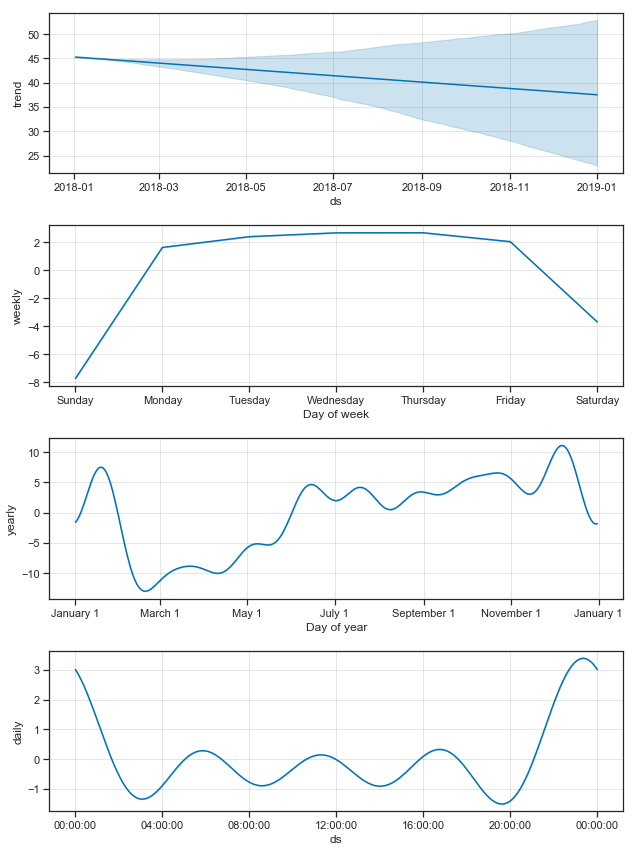